In [10]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

style.use("fivethirtyeight")
from google.colab import drive
drive.mount('/content/drive')

pd.set_option("display.max_columns", 99)
os.chdir("/content/drive/MyDrive/projects/ssc23-case-comp")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# load weather_prod data
weather_prod = pd.read_csv("./data/user_data/02_counterfactual_analysis/weather_prod_final.csv")

# column "is_flag" is 1 if extreme_flag is > 0, 0 otherwise
flags = ["tmax_flag", "tmin_flag", "total_flag"]
# i_flag = int(sys.argv[1]) - 1
i_flag = 0
flag = flags[i_flag]

result_filename = "./data/user_data/02_counterfactual_analysis/_allTogether/result_" + flag + ".csv"

weather_prod["is_flag"] = np.where(weather_prod[flag] > 0, 1, 0)
weather_prod["log_population"] = np.log(weather_prod["Population"])
weather_prod.head()
print(weather_prod["is_flag"].value_counts())
# There exists a class imbalance.

1    3601
0    1700
Name: is_flag, dtype: int64


## Covariates
- We control for possible confounders that can affect industrial productions:
    * Comodity prices, oil prices (indices downloaded from Statistics Canada)
    * USD currency (downloaded from Bank of Canada)
- We take the first 5 PC loadings from the above covariates because they may be highly correlated to each other.
- Other covariates: 
    * Geographical information (lat, lon)
    <!-- * Province, because industrial production may be affected by provincial policies. -->
    * Year
    * Population

In [8]:
# - load covariates, filter out month == 12
covar_df = pd.read_csv("./data/user_data/_covariates/ppi_and_usd_imputed.csv")

# - group by year, compute the average of each covariate.
covar_df = covar_df.drop(columns = ["date", "month"]).reset_index(drop = True)
covar_df = covar_df.groupby("year").mean().reset_index()
covar_df.head()

# - min max scale each column of covar_df
from sklearn.preprocessing import MinMaxScaler
covar_sub = covar_df.drop(columns = ["year"])
# covar_sub = covar_df.copy()
covar_scaled = pd.DataFrame(MinMaxScaler().fit_transform(covar_sub), columns = covar_sub.columns)

# - Perform PCA on the scaled covariates
from sklearn.decomposition import PCA
n_pca = 5
pca = PCA(n_components=n_pca)
pca.fit(covar_scaled)
print(np.sum(pca.explained_variance_ratio_)) # 5PCs explain over 98% of the variance in the data
covar_pca = pd.DataFrame(pca.transform(covar_scaled), columns = ["cPC" + str(i) for i in range(1, n_pca+1)])

# - Add year column back
covar_pca = pd.concat([covar_df.loc[:, "year"], covar_pca], axis = 1)
covar_pca.head()

# - merge covar_pca to weather_prod by year
weather_prod_raw = pd.merge(weather_prod, covar_pca, on = "year", how = "left")

# - create dummy variables for provincename
weather_prod_df = pd.concat([weather_prod_raw.drop(columns = ["provincename"]), pd.get_dummies(weather_prod_raw.provincename, columns = ["provincename"], drop_first=True)], axis = 1)
weather_prod_df.head()

# - Replace " " with  "_" in all column names
weather_prod_df.columns = weather_prod_df.columns.str.replace(" ", "_")
binary_provs = weather_prod_df.columns[-9:].tolist()

0.9872854521184629


## Counterfactual analysis: propensity score weighting

* Here, we compute the propensity score $P(T = 1 | X)$ where:
  *  $T = 1$ if is_flag = True, 0 otherwise.
  *  $X$ is a set of covariates we want to adjust for, which includes:
     *  year, population, location (lat, lon), cPCs (USD currency, oil price, commodity prices)
  *  Fit logistic regression model to predict $T$ from $X$.
  *  Use propensity score weighting to compute the treatment effect, adjusting for covariates.
  *  Use bootstrap sampling to compute the mean and standard error of the average treatment effect (ATE) of extreme weather on the log(production).
*  The advantage of propensity score weighting is that we can utilize all samples in the dataset, unlike in matching-based methods.
*  In this notebook we consider X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction as an example.

mean(ATE): -0.10728804990706527
se(ATE): 0.03519953003601301
95% C.I.: (-0.182944620775887, -0.03964320898984126)


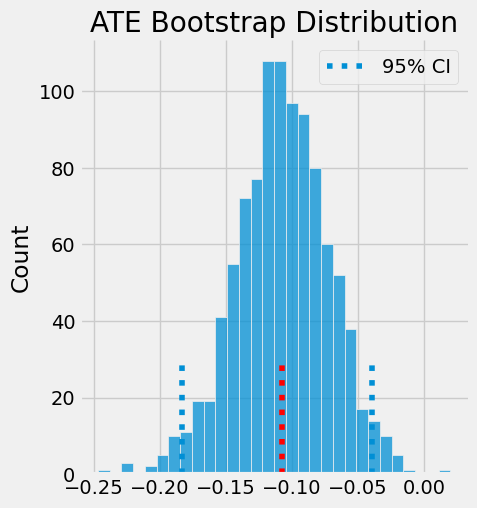

In [11]:
# - extract columns that start with "X"
# prod_cols = [col for col in weather_prod.columns if col.startswith("X")]
prod_cols = ["X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction"]
covar_cols = ["year", "log_population", "lat", "lon", "cPC1", "cPC2", "cPC3", "cPC4", "cPC5"]

# - Iterate over industries
prod_ate = pd.DataFrame(columns = ["Industry", "mean(ATE)", "se(ATE)", "lower_95ci", "upper_95ci", "sig"])

for i, prod in enumerate(prod_cols):
    
    # prod = prod_cols[8]
    # print(prod)

    T = "is_flag"
    # Y = prod_cols[9] # X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction
    X = covar_cols

    df_sub = weather_prod_df.loc[:, [T, prod] + X].dropna()
    df_sub["log_prod"] = np.log(df_sub[prod] + 1)
    Y = "log_prod"

    # - Use bootstrapping to compute the mean and standard error of ATE
    from joblib import Parallel, delayed # for parallel processing

    # define function that computes the IPTW estimator
    def run_ps(df, X, T, y):
        
        # estimate the propensity score using logistic regression.
        # - make prediction to get propensity score.
        ps = LogisticRegression(C=1e6, max_iter = 1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
        
        weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
        return np.mean(weight * df[y]) # compute the ATE

    np.random.seed(42)

    # run 1000 bootstrap samples
    bootstrap_sample = 1000
    ates = Parallel(n_jobs = 10)(delayed(run_ps)(df_sub.sample(frac=1, replace=True), X, T, Y)
                            for _ in range(bootstrap_sample))
    ates = np.array(ates)


    # - The ATE is then the mean of the bootstrap samples, and CI is the 2.5% and 97.5% quantiles of the bootstrap samples.
    mean_ate = np.round(np.mean(ates), 3) # IPTW (inverse probability of treatment weighted) estimator
    se_ate = np.round(np.std(ates), 3)
    lowerci_ate = np.round(np.percentile(ates, 2.5), 3)
    upperci_ate = np.round(np.percentile(ates, 97.5), 3)
    
    is_sig = (lowerci_ate > 0) | (upperci_ate < 0) # is_sig is True if 0 is not in the 95% CI
    
    # - Store result
    prod_ate.loc[i] = [prod, mean_ate, se_ate, lowerci_ate, upperci_ate, is_sig]
        
    # prod_ate.to_csv(result_filename, index = False)

# - The ATE is then the mean of the bootstrap samples, and CI is the 2.5% and 97.5% quantiles of the bootstrap samples.
print(f"mean(ATE): {ates.mean()}")
print(f"se(ATE): {ates.std()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

sns.displot(ates, kde=False)
plt.vlines(x = ates.mean(), ymin = 0, ymax = 30, linestyles="dotted", colors= "red")
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();